In [22]:
! pip install numpy

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
# Paths
raw_data_folder = "C:/BDA proj/raw_data"
cleaned_data_folder = "C:/BDA proj/cleaned_datasets"

In [25]:


def preprocess_dataset(file_path, industry_name):
    # Try reading the dataset with a specific encoding
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')  # or 'latin1', 'utf-16', etc.
    except UnicodeDecodeError:
        print(f"Error reading {file_path} with 'ISO-8859-1' encoding. Trying 'utf-16'...")
        df = pd.read_csv(file_path, encoding='utf-16')

    
    # Standardize column names
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    
    # Handle missing values
    df.fillna("Not disclosed", inplace=True)
    
    # Add the industry column and remove underscores
    df["industry"] = industry_name.replace("_", " ")
    

    # Process "experience" column to ensure it's treated as string without altering original column
    if "experience" in df.columns:
        df["experience"] = df["experience"].astype(str)

        # Create a new column for cleaned experience (removes 'Yrs' text) but keeps the original intact
        df["experience_cleaned"] = df["experience"].str.replace(" Yrs", "").str.replace(" YR", "").str.strip()

        # Function to extract min and max experience from the cleaned column
        def extract_experience(exp):
            exp = exp.strip()
            try:
                if "-" in exp:
                    min_exp, max_exp = exp.split("-")
                    return int(min_exp), int(max_exp)
                else:
                    # If there's a single value, consider it as both min and max experience
                    return int(exp), int(exp)
            except ValueError:
                return 0, 0  # Default to 0,0 if there's an issue with the value

        # Apply the function to create min_experience and max_experience columns
        df[['min_experience', 'max_experience']] = df["experience_cleaned"].apply(lambda x: pd.Series(extract_experience(x)))
    
    # Process "salary" column (split into min_salary and max_salary)
    if "salary" in df.columns:
        def split_salary(salary):
            try:
                salary = salary.replace(" Lacs PA", "").replace(",", "")  # Remove commas and "Lacs PA"
                if "-" in salary:
                    min_salary, max_salary = salary.split("-")
                    return [float(min_salary), float(max_salary)]
                else:
                    return [float(salary), float(salary)]  # If no range, set min and max as same
            except ValueError:
                return [0.0, 0.0]  # Default to 0 if conversion fails

        # Create min_salary and max_salary columns
        df[['min_salary', 'max_salary']] = df["salary"].apply(lambda x: pd.Series(split_salary(x)))
        df["is_salary_disclosed"] = df["salary"].apply(lambda x: "Not disclosed" not in x)
        
        # Calculate avg_salary from min_salary and max_salary
        df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2

    # Process "locations" column
    if "locations" in df.columns:
        df["locations"] = df["locations"].str.replace("[", "").str.replace("]", "").str.replace("'", "")
        df["locations"] = df["locations"].str.split(", ")  # Split into multiple locations

    # If multiple locations are present, explode them for better analysis
    if "locations" in df.columns:
        df = df.explode("locations").reset_index(drop=True)  # One row per location
    
    # Process "dates" columns (posting date and days ago)
    if "dates" in df.columns and "presentdate" in df.columns:
        df["days_ago"] = df["dates"].str.extract(r"(\d+)").astype(float)
        df["posting_date"] = pd.to_datetime(df["presentdate"], format="%d-%m-%Y") - pd.to_timedelta(df["days_ago"], unit="D")
        df.drop(["dates", "presentdate"], axis=1, inplace=True)  # Drop redundant columns

    # Add "job_age_days" column
    if "posting_date" in df.columns:
        today = pd.Timestamp.today()
        df["job_age_days"] = (today - df["posting_date"]).dt.days  # Calculate age of the job posting

    # Process "skills" column (remove square brackets)
    if "skills" in df.columns:
        df["skills"] = df["skills"].str.replace("[", "").str.replace("]", "").str.replace("'", "")
        df["skills"] = df["skills"].str.split(", ")  # Split into multiple skills

    # If multiple skills are present, explode them for better analysis
    if "skills" in df.columns:
        df = df.explode("skills").reset_index(drop=True)
    
    # Normalize job roles for future NLP analysis
    if "roles" in df.columns:
        df["roles"] = df["roles"].str.lower().str.replace("-", " ").str.strip()
    
    # Derive a new feature: "seniority_level"
    if "min_experience" in df.columns:
        df["seniority_level"] = df["min_experience"].apply(
            lambda x: "Entry" if x < 3 else "Mid" if x < 8 else "Senior"
        )
    
    # Clean company names for consistency
    if "companies" in df.columns:
        df["companies"] = df["companies"].str.strip().str.title()

    # Derive additional features for analytics
    df["is_remote"] = df["locations"].apply(lambda x: "Remote" in x if isinstance(x, str) else False)  # Remote jobs
    df["is_high_salary"] = df["avg_salary"] > 10  # Mark jobs offering high salaries (>10 LPA)
    
    return df


In [26]:
def save_combined_data(raw_data_folder, cleaned_data_folder):
    all_cleaned_dfs = []  # To store dataframes for analytics

    # Process all files in the raw_data folder
    for file_name in os.listdir(raw_data_folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(raw_data_folder, file_name)
            industry_name = os.path.splitext(file_name)[0]  # Extract industry name from filename
            
            # Preprocess the dataset
            cleaned_df = preprocess_dataset(file_path, industry_name)
            all_cleaned_dfs.append(cleaned_df)  # Append for further analysis
            
            # Save cleaned dataset to the cleaned_data folder
            cleaned_file_path = os.path.join(cleaned_data_folder, file_name)
            cleaned_df.to_csv(cleaned_file_path, index=False)

    # Combine all datasets into one for overall analysis
    combined_df = pd.concat(all_cleaned_dfs, ignore_index=True)

    # Dynamically create a file name with current date-time to avoid overwriting
    combined_file_name = f"combined_data.csv"
    combined_file_path = os.path.join(cleaned_data_folder, combined_file_name)
    
    # Save the combined dataset
    combined_df.to_csv(combined_file_path, index=False)

    print(f"All datasets have been preprocessed and saved to the '{cleaned_data_folder}' folder.")
    print(f"Combined dataset has been saved to '{combined_file_path}'.")

# Call the save_combined_data function
save_combined_data(raw_data_folder, cleaned_data_folder)


All datasets have been preprocessed and saved to the 'C:/BDA proj/cleaned_datasets' folder.
Combined dataset has been saved to 'C:/BDA proj/cleaned_datasets\combined_data.csv'.


In [27]:
combined_df = pd.read_csv('C:\BDA proj\cleaned_datasets\combined_data.csv')

In [28]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264710 entries, 0 to 264709
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   roles                264710 non-null  object 
 1   companies            264710 non-null  object 
 2   locations            264710 non-null  object 
 3   experience           264710 non-null  object 
 4   skills               264710 non-null  object 
 5   salary               264710 non-null  object 
 6   industry             264710 non-null  object 
 7   experience_cleaned   264710 non-null  object 
 8   min_experience       264710 non-null  int64  
 9   max_experience       264710 non-null  int64  
 10  min_salary           264710 non-null  float64
 11  max_salary           264710 non-null  float64
 12  is_salary_disclosed  264710 non-null  bool   
 13  avg_salary           264710 non-null  float64
 14  days_ago             263266 non-null  float64
 15  posting_date     

<Axes: >

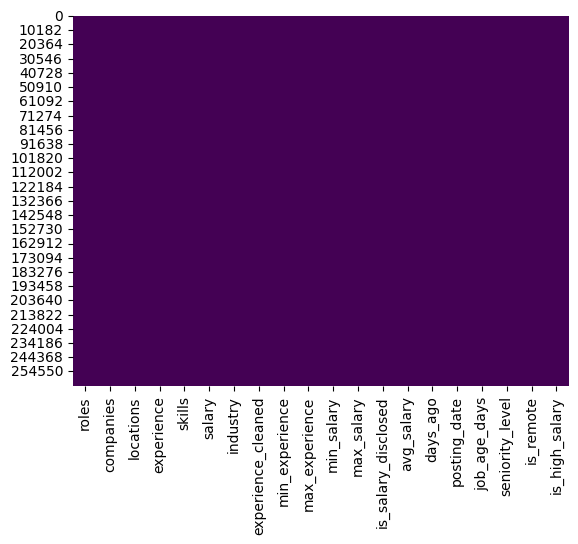

In [29]:
# Check missing values
missing_values = combined_df.isnull().sum().sort_values(ascending=False)
sns.heatmap(combined_df.isnull(), cbar=False, cmap="viridis")

The absence of breaks in the color suggests that there are no missing values in any of the columns.

<Axes: ylabel='industry'>

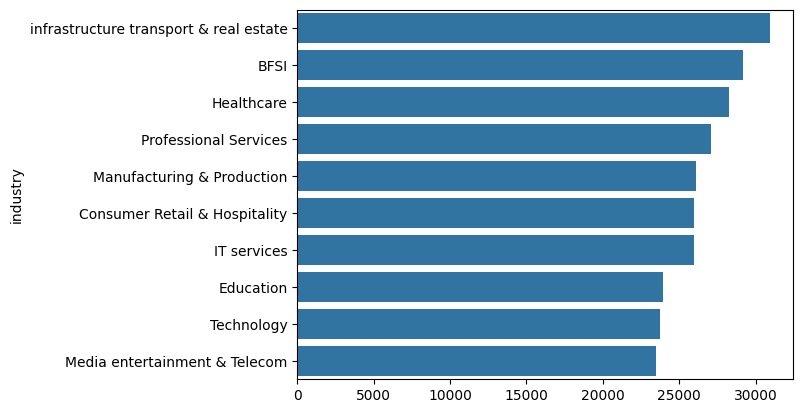

In [30]:
# Example for top industries
top_industries = combined_df['industry'].value_counts().head(10)
sns.barplot(y=top_industries.index, x=top_industries.values)


<Axes: xlabel='min_experience', ylabel='avg_salary'>

c:\Users\AYUSHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\AYUSHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


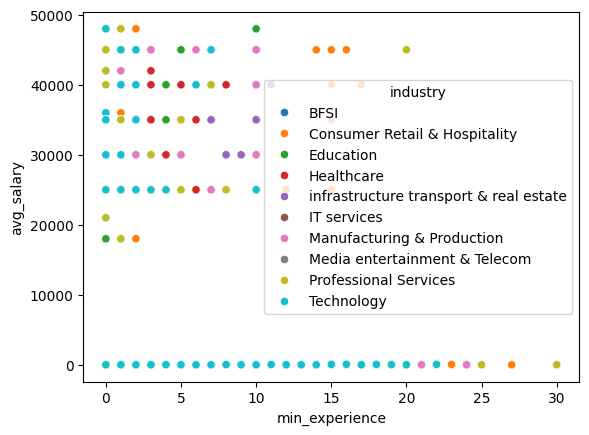

In [31]:
# Example: Salary vs. Experience
sns.scatterplot(x='min_experience', y='avg_salary', data=combined_df, hue='industry')


This scatter plot shows the relationship between **minimum experience** and **average salary** across various industries. It highlights that industries like BFSI and Technology tend to offer higher salaries even at lower experience levels, while salaries generally increase with experience. The clustering at zero experience indicates abundant entry-level roles with varying pay.

In [32]:
# Example: Encode 'roles' column
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
combined_df['roles_encoded'] = encoder.fit_transform(combined_df['roles'])

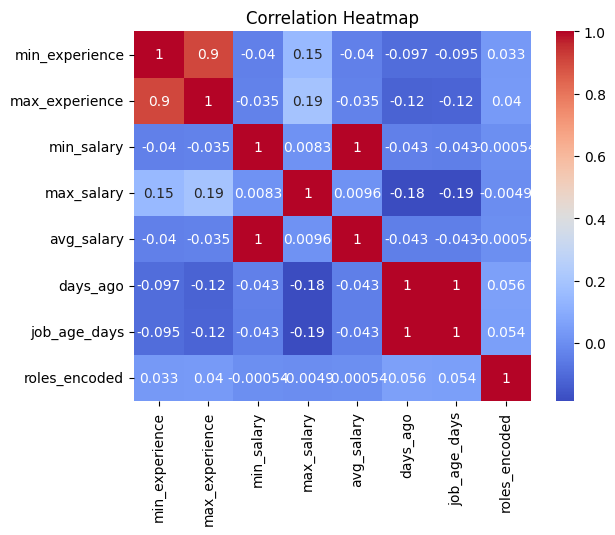

In [33]:
numeric_df = combined_df.select_dtypes(include=['number'])

# Calculate correlation
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## Correlation Heatmap Analysis

The heatmap illustrates the relationships between key numerical variables in the dataset. Below are the key observations:

1. **Strong Positive Correlation:**
   - `min_experience` and `max_experience` have a high correlation of **0.9**, indicating jobs requiring higher minimum experience often demand higher maximum experience.

2. **Weak Correlation with Salaries:**
   - Both `min_experience` and `max_experience` show weak correlations with `min_salary`, `max_salary`, and `avg_salary`. Experience seems to have a limited impact on salary levels.

3. **Negative Correlation with Job Posting Age:**
   - Variables like `days_ago` and `job_age_days` have a **negative correlation** with salary values, suggesting that older job postings tend to offer slightly lower salaries.

4. **Encoded Roles:**
   - `roles_encoded` has negligible correlations with other variables, indicating job roles might not directly influence salary or experience requirements.

### Conclusion:
While experience levels strongly correlate with each other, their impact on salary levels is limited in this dataset. Additionally, older job postings tend to have slightly lower salary ranges.


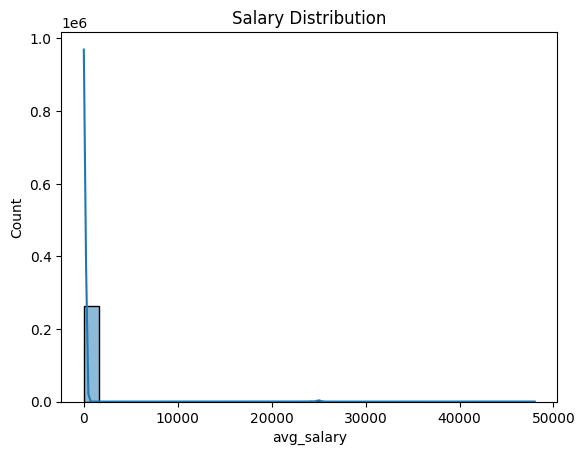

In [34]:
# Histogram
sns.histplot(combined_df['avg_salary'], bins=30, kde=True)
plt.title('Salary Distribution')
plt.show()


### Insights from the Salary Distribution Plot
- **Majority of Salaries**: The majority of the salaries are clustered at the very low end, close to 0.
- **Significant Spike**: There is a significant spike in the count at the lower end of the salary range.
- **Sparse Higher Salaries**: There are very few instances of higher salaries, as indicated by the sparse data points beyond the initial spike.

This distribution suggests that most individuals have very low average salaries, with very few earning significantly higher amounts.


In [35]:
industry_insights = combined_df.groupby('industry').agg(
    job_count=('industry', 'size'),
    avg_salary=('avg_salary', 'mean')
).sort_values('job_count', ascending=False)

print(industry_insights)


                                        job_count  avg_salary
industry                                                     
infrastructure transport & real estate      30915  174.355484
BFSI                                        29208  178.239979
Healthcare                                  28231  113.140761
Professional Services                       27099  182.906255
Manufacturing & Production                  26083  141.662407
Consumer Retail & Hospitality               26004  236.321793
IT services                                 25967   24.771960
Education                                   23950  165.423698
Technology                                  23744  147.581764
Media entertainment & Telecom               23509  107.953279


- **Infrastructure, Transport & Real Estate**: Most jobs available but moderate salaries. 
- **Consumer Retail & Hospitality**: Highest average salary with moderate job count. 
- **IT Services**: High job count but lowest average salary. 
- **Healthcare**: Many jobs but lower average salary.

### Role trends

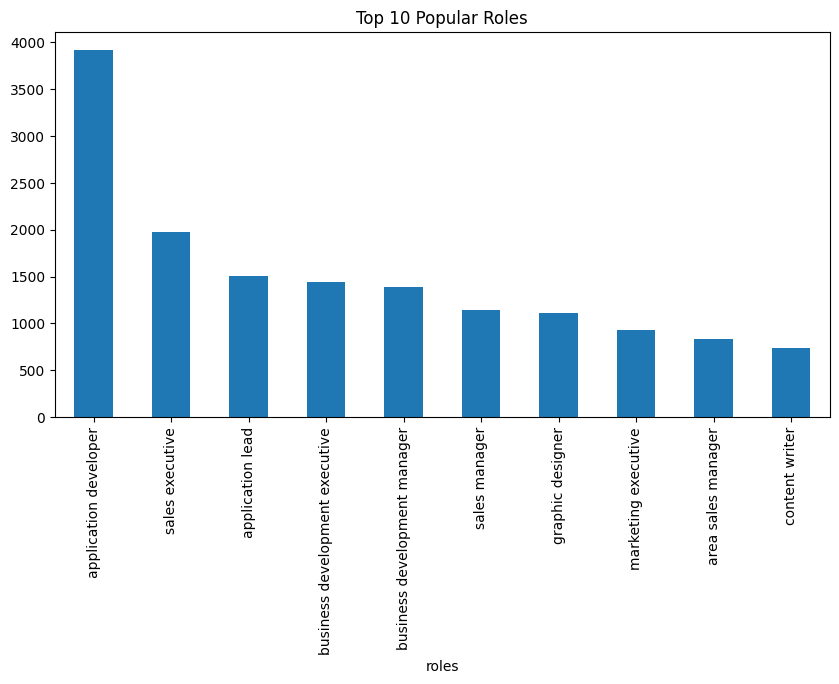

In [36]:
role_counts = combined_df['roles'].value_counts()
role_counts.head(10).plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 Popular Roles')
plt.show()


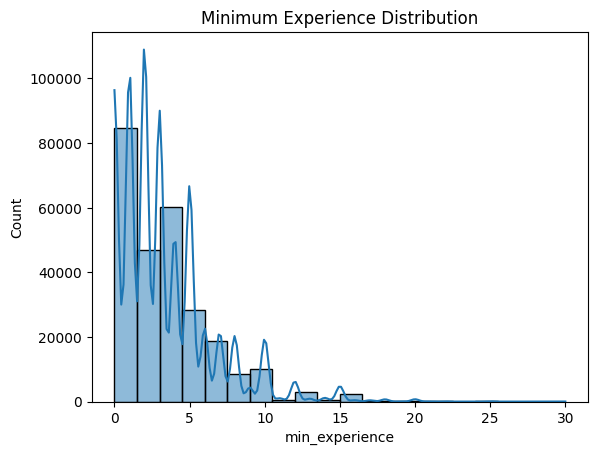

In [37]:
sns.histplot(combined_df['min_experience'], bins=20, kde=True)
plt.title('Minimum Experience Distribution')
plt.show()


The high frequency at the lower end suggests that the majority of jobs in the dataset require relatively low minimum experience.